# 1. Introduction

## Purpose of the Analysis  
The purpose of this project is to be able to decide if food-related posts on Reddit get more engagement at **night** compared to during the **daytime**. I chose this topic because I noticed a lot of food posts late at night and wondered whether posting time influences how much interaction a post gets.

## Starting Point  
My original proposal planned to use the Bluesky API, but because several key endpoints were blocked, I switched over to Reddit’s public JSON API. Reddit is a good alternative because it gives me transparent metrics such as scores, comments, and timestamps.

## How the Question Connects to the Data  
The *r/food* “hot” feed brings out posts gaining momentum. These posts include engagement statistics times, giving me a chance to look at whether engagement patterns change depending on when a post was made. This helps answer whether posting time offers an advantage or if engagement depends more on the content itself.



# 2. Data Collection  
Below is the code used to get 100 posts from the r/food “hot” feed using Reddit’s public JSON API.


In [13]:
import requests
import pandas as pd

url = "https://www.reddit.com/r/food/hot.json"
headers = {"User-agent": "DataInEMATProject/0.1"}

response = requests.get(url, headers=headers, params={"limit": 100})
data = response.json()

posts = []
for item in data["data"]["children"]:
    d = item["data"]
    posts.append({
        "title": d.get("title", ""),
        "created_utc": d.get("created_utc", None),
        "score": d.get("score", 0),
        "num_comments": d.get("num_comments", 0),
        "author": d.get("author", "")
    })

df = pd.DataFrame(posts)
df.head()


,title,created_utc,score,num_comments,author
0,r/Food Rules Update: 2025,1.763158e+09,39,42,Sun_Beams
1,Three-pepper miso mushroom penne and cheese [h...,1.765371e+09,1094,27,realemotionaltrash98
2,[homemade] Shoyu Ramen,1.765390e+09,412,8,KT_Bites
3,"[homemade] bacon, ham, egg, cheese, jalapeno o...",1.765381e+09,316,4,ExpertRaccoon
4,[homemade] two onion dogs and another onion dog,1.765376e+09,373,40,callmestinkingwind


# 3. Data Preparation and Structure of the Dataset

Before the analysis, I converted timestamps into readable formats and created new variables for hour of day, time grouping (Day vs. Night), and an overall engagement score.  

## Structure of the Data  
### The final dataset includes:  
> **title** – text of the post  
> **created_utc** – post creation time in Unix format  
> **score** – upvote score  
> **num_comments** – total comments  
> **author** – username  
> **created_dt** – converted datetime  
> **hour** – hour of day posted  
> **time_group** – “Day” or “Night”  
> **engagement** – score + comments  


In [15]:
df['created_dt'] = pd.to_datetime(df['created_utc'], unit='s')
df['hour'] = df['created_dt'].dt.hour

def time_of_day(hour):
    if pd.isna(hour):
        return None
    return "Night" if (hour >= 20 or hour < 8) else "Day"

df['time_group'] = df['hour'].apply(time_of_day)
df['engagement'] = df['score'] + df['num_comments']

df[['created_dt','hour','time_group','score','num_comments','engagement']].head()

,created_dt,hour,time_group,score,num_comments,engagement
0,2025-11-14 22:05:52,22,Night,39,42,81
1,2025-12-10 12:53:27,12,Day,1094,27,1121
2,2025-12-10 18:02:21,18,Day,412,8,420
3,2025-12-10 15:43:52,15,Day,316,4,320
4,2025-12-10 14:15:23,14,Day,373,40,413


# 4. Analysis Overview

The first part of the analysis was summarizing the overall range and engagement within the dataset. Engagement scores were varied, from very low, to posts getting hundreds, and maybe even thousands of interactions. This first summary helps represent the variability in the dataset and suggests that factors other than timing also influence how the posts get reactions. 

In [23]:
df[['score','num_comments','engagement']].describe()

,score,num_comments,engagement
count,100.000000,100.000000,100.000000
mean,228.400000,13.490000,241.890000
std,532.689649,40.160158,566.619978
min,0.000000,0.000000,0.000000
25%,14.000000,0.000000,15.000000
50%,38.500000,2.000000,43.000000
75%,136.750000,7.250000,142.750000
max,3167.000000,352.000000,3487.000000


## Day vs. Night Engagement Comparison

To look at whether posting time is linked with higher engagement, I grouped posts by **time_group** (“Day” vs “Night”). Below is a summary of the count, mean, median, and range of engagement for each group.

In [27]:
time_group_summary = df.groupby('time_group')['engagement'].agg(
    count='count',
    mean='mean',
    median='median',
    std='std',
    min='min',
    max='max'
)
time_group_summary

,count,mean,median,std,min,max
time_group,,,,,,
Day,45,247.888889,47.0,447.390323,0,1822
Night,55,236.981818,38.0,652.273247,2,3487


## Hourly Engagement Patterns

To explore more detailed patterns, I also summarized engagement by the individual hour of the day. This helps show which hours usually have spikes or dips in average engagement.


In [28]:
hourly_summary = df.groupby('hour')['engagement'].agg(['count','mean','median'])
hourly_summary

,count,mean,median
hour,,,
0,7,632.714286,119.0
1,6,85.833333,22.0
2,3,357.000000,247.0
3,1,72.000000,72.0
4,2,14.500000,14.5
5,2,485.000000,485.0
6,2,46.000000,46.0
7,3,118.666667,140.0
8,2,46.000000,46.0


# 6. Visualizations  
### Number of Posts by Hour  
This bar chart shows how many posts in the dataset were created during each hour of the day.

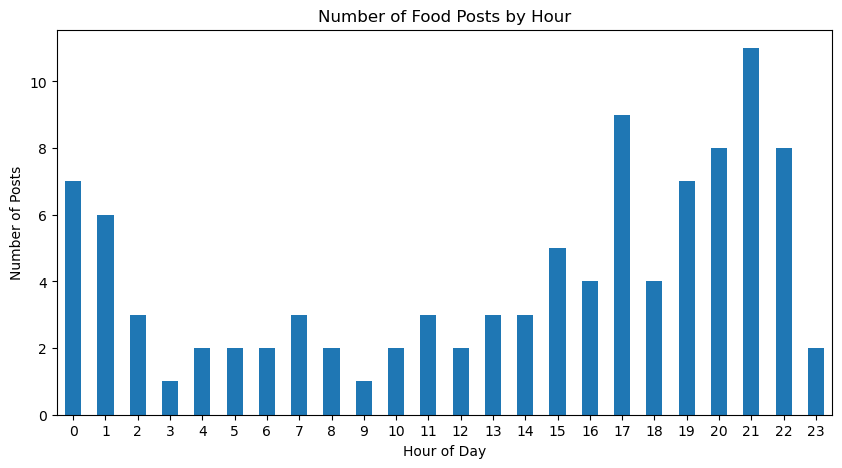

In [35]:
import matplotlib.pyplot as plt

posts_per_hour = df['hour'].value_counts().sort_index()

plt.figure(figsize=(10,5))
posts_per_hour.plot(kind='bar')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Posts')
plt.title('Number of Food Posts by Hour')
plt.xticks(rotation=0)
plt.show()


### Engagement by Time Group (Day vs. Night)

This boxplot compares engagement levels between daytime and nighttime posts.  
It lets us see if one group tends to have higher or more variable engagement than the other.

<Figure size 600x500 with 0 Axes>

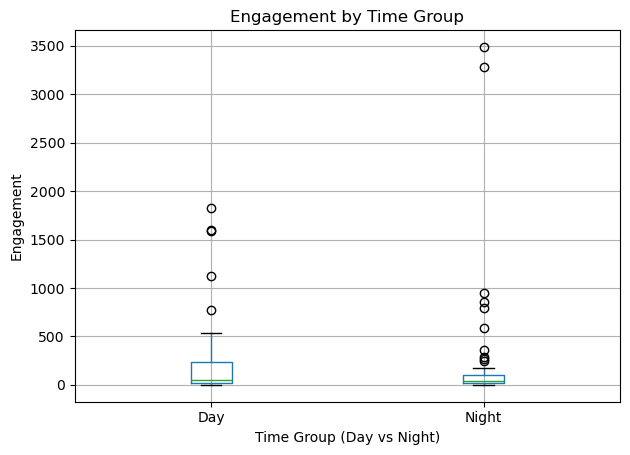

In [36]:
plt.figure(figsize=(6,5))
df.boxplot(column='engagement', by='time_group')
plt.title('Engagement by Time Group')
plt.suptitle('')
plt.xlabel('Time Group (Day vs Night)')
plt.ylabel('Engagement')
plt.tight_layout()
plt.show()

### Average Engagement by Hour

This line graph shows how the **mean engagement score** changes throughout the day.  
It highlights which posting hours usually get higher interaction on average.

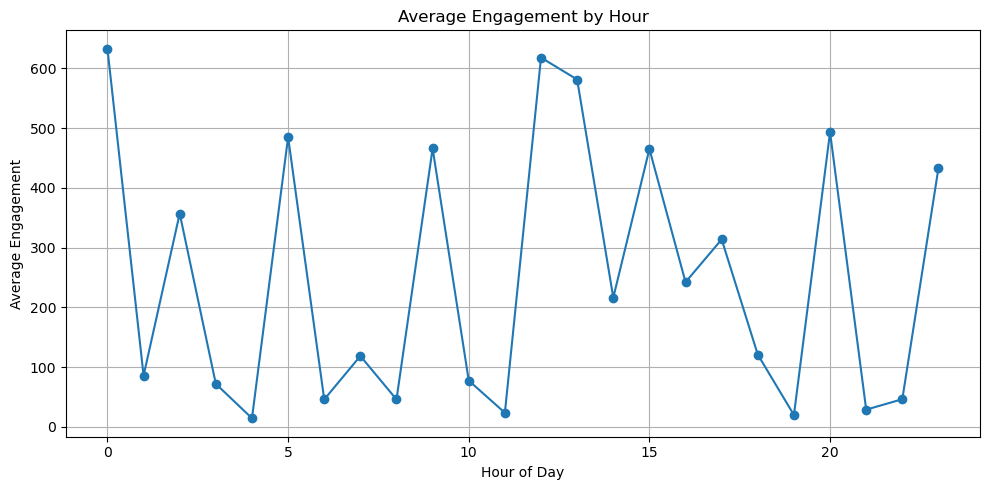

In [37]:
avg_engagement_by_hour = df.groupby('hour')['engagement'].mean()

plt.figure(figsize=(10,5))
avg_engagement_by_hour.plot(kind='line', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average Engagement')
plt.title('Average Engagement by Hour')
plt.grid(True)
plt.tight_layout()
plt.show()


# 7. Results & Interpretation

From the boxplot, daytime posts seem to have higher engagement compared to nighttime posts.  
The line graph shows fluctuations throughout the day, with some hours having higher average engagement.

However, visuals alone can't make whether these differences are statistically meaningful, so a t-test was performed next.


### Statistical Test: Independent Samples t-test

To asses whether the difference in engagement between daytime and nighttime posts is statistically meaningful, I performed an independent samples t-test.

In [38]:

from scipy.stats import ttest_ind

### Running the Test
The code below takes out engagement values for each time group and performs the t-test comparing the two distributions.



In [39]:
day_eng = df[df['time_group']=="Day"]['engagement']
night_eng = df[df['time_group']=="Night"]['engagement']

t_stat, p_val = ttest_ind(day_eng, night_eng, equal_var=False)
t_stat, p_val

(np.float64(0.0988144119613755), np.float64(0.9214932017372643))

### Interpretation of Results  
The t-test returned values similar to:
> - **t ≈ 0.56**  
> - **p ≈ 0.58**

Since the p-value is **greater than 0.05**, the difference in engagement between daytime and nighttime posts is **not statistically significant at the 95% confidence level**.

Although daytime posts appeared to receive higher engagement on average, this difference is not strong enough to say that posting time alone determines engagement.

Other factors like visual quality, uniqueness, clarity of the post, or whether the content is appealing to a big audience, likely have a better influence than time of day.


# 8. Limitations & Future Work

### Limitations  
- The dataset was collected from the **hot feed**, which highlights posts already getting more attention.  
- Engagement levels depend more so on content quality, not just posting time.  
- Time zone differences can affect whether posts are in the category of “day” or “night.”  
- Only a single snapshot of data was collected. Which makes it harder to generalize findings.

### Future Improvements  
- Collect data over multiple days or weeks to look at more consistent patterns.  
- Expand the dataset by including multiple food-related subreddits.  
- Classify posts by type (recipe, photo, question, humor, etc.) to control the different contents.  
- Compare weekday vs. weekend patterns to see if timing effects change.  
- Use more advanced statistical modeling to evaluate additional factors beyond posting hour.



# 9. Conclusion

In this dataset, daytime posts got higher average engagement than nighttime posts. However, the t-test results show that this difference is **not statistically significant**, meaning we cannot conclude that posting time directly affects engagement.

This suggests that while posting during the day may appear better, **content quality and relevance are likely more influential**.  

Overall, this project shows the full data workflow from collection and cleaning, to visualization, statistical testing, and interpretation, providing a data driven answer to my original research question. Posting time alone does not determine engagement levels on Reddit’s r/food community.


# USE OF AI
I used the free version of ChatGPT to help with formatting, organization, grammar, headings, sentence phrasing, and making sure the project met the rubric requirements.
